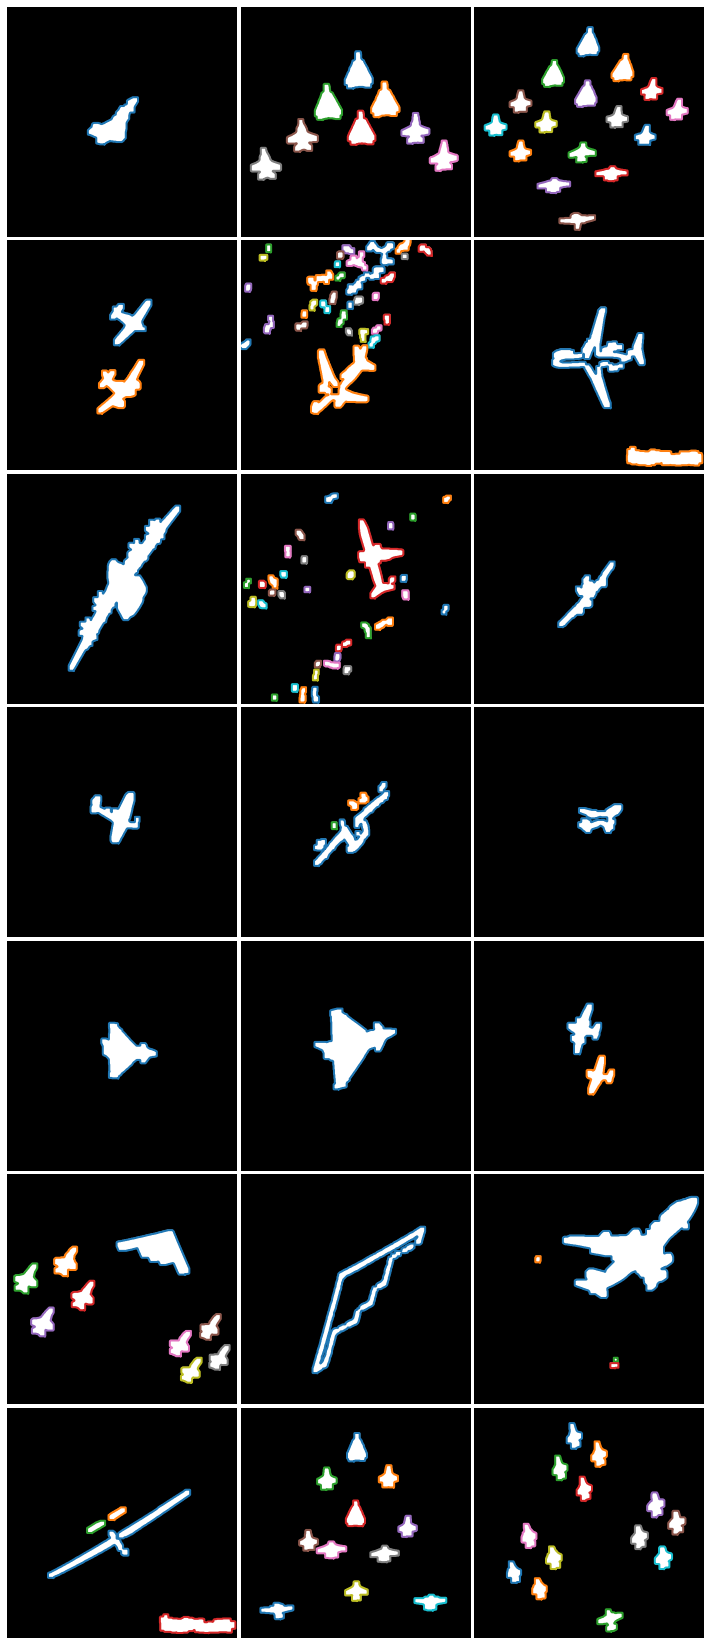

In [4]:
from skimage import img_as_ubyte, img_as_float, io, filters, measure, morphology, feature, restoration, segmentation
from skimage.filters import threshold_otsu, threshold_local
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt 
from scipy import ndimage as ndi
import numpy as np

def transform(image: np.ndarray) -> np.ndarray:
    image = img_as_ubyte(rgb2gray(image))

    block_size = 25
    local_thresh = threshold_local(image, block_size, offset=10)
    binary_local = image > local_thresh

    binary_local = morphology.remove_small_holes(binary_local)
    binary_local = filters.median(binary_local, morphology.disk(4))
    binary_local = morphology.closing(binary_local, morphology.disk(1))
    binary_local = filters.median(binary_local, morphology.disk(1))
    binary_local = filters.gaussian(binary_local, sigma=1.2)
    binary_local = ndi.binary_fill_holes(binary_local - 1)
    
    return binary_local

def findContours(image: np.ndarray):
    return measure.find_contours(image, 0.99, fully_connected='high')

def readImages(filenames: list, size: tuple = (600,600)) -> list:
    return [resize(io.imread(file), size) for file in filenames]

def draw(images: list, contours: list, figsize: tuple, 
         nrows_ncols: tuple, axes_pad: float = 0.05) -> None:
    
    if len(images) != nrows_ncols[0] * nrows_ncols[1]:
        print("Warning: number of images (", len(images), ") does not match the shape of plot", nrows_ncols)
    
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=nrows_ncols, axes_pad=axes_pad)
    
    for ax, img, contour in zip(grid, images, contours):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.axis('off')
        for c in contour:
            ax.plot(c[:, 1], c[:, 0], linewidth=2)
            
    fig.savefig("plot.pdf")     

def getFilenamesFromDirectory(directory: str) -> list:
    import os
    files = [directory + i for i in os.listdir(directory)]
    return files

filenames = getFilenamesFromDirectory("img/")
images = readImages(filenames)
transformed_images = [transform(image) for image in images]
contours = [findContours(image) for image in transformed_images]
draw(transformed_images, contours, figsize=(30,30), nrows_ncols=(7,3))
